## This Jupyter Notebook is used to do pre-processing work and model

#### Cleaned Dataset 
- case 1: lemmatized_text_case1.csv
- case 2: lemmatized_text_case2.csv

- Case 1

$stock_{\text{price_change}}(t) =
            \begin{cases}
            sp_{open}(t)-sp_{close}(t-1) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            sp_{close}(t)-sp_{open}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            sp_{open}(t+1)-sp_{close}(t) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
         \\
          index_{\text{price_change}}(t) =
            \begin{cases}
            ip_{open}(t)-ip_{close}(t-1) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            ip_{close}(t)-ip_{open}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            ip_{open}(t+1)-ip_{close}(t) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
          \\
          $

- Case 2

$stock_{\text{price_change}}(t) =
            \begin{cases}
            sp_{close}(t)-sp_{open}(t) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            sp_{open}(t+1)-sp_{close}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            sp_{close}(t+1)-sp_{open}(t+1) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
\\
index_{\text{price_change}}(t) =
            \begin{cases}
            ip_{close}(t)-ip_{open}(t) & \quad \text{if } \text{8-K is released before normal trading hours}\\
            ip_{open}(t+1)-ip_{close}(t)  & \quad \text{if } \text{8-K is released during normal trading hours}\\
            ip_{close}(t+1)-ip_{open}(t+1) & \quad \text{if } \text{8-K is released after normal trading hours}
            \end{cases}
\\
$

$price_\text{change}(t) = stock_\text{price_change}(t) - index_\text{price_change}(t)$

$signal(t) = 
          \begin{cases}
          \text{up} & \quad \text{if } price_\text{change}(t)>0.01\\
          \text{stay} &\quad \text{if } -0.01<=price_\text{change}(t)<=0.01\\
          \text{down} &\quad \text{if } price_\text{change}(t)<0.01\\
          \end{cases}
          $

**<font color='teal'> Start by loading the necessary packages and printing out our current working directory just to confirm we are in the correct project directory. </font>**

In [17]:
from bs4 import BeautifulSoup
#import datetime
from datetime import datetime,date
import unicodedata
import requests
import pandas as pd
import numpy as np
from time import sleep
import math
from config import Config
import dateutil.relativedelta
import pandas_market_calendars as mcal
import os
import io
import re
from tqdm import tqdm
import gc
import ast
import glob
from function import *
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
tqdm.pandas()


import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GRU,CuDNNGRU,Input, LSTM, Embedding, Bidirectional
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, BatchNormalization
from keras.layers import concatenate as lconcat
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras import backend as K


#sess_config.gpu_options.allow_growth = True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
from sklearn.metrics import roc_auc_score, confusion_matrix
from keras.utils import np_utils,plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

os.getcwd()

G:\Data\Machine_Learning_Library\learn_others\learn_from_others\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


'G:\\Data\\Machine_Learning_Library\\spring_board_data_science\\Capstone\\Capstone2\\src'

### Preprocessing and Training Data Development

In [2]:
df1 = pd.read_csv("../clean_data/lemmatized_text_case1.csv",parse_dates =['release_date'])
df2 = pd.read_csv("../clean_data/lemmatized_text_case2.csv",parse_dates =['release_date'])

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99242 entries, 0 to 99241
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ticker             99242 non-null  object        
 1   cik                99242 non-null  float64       
 2   txt_link           99242 non-null  object        
 3   doc_name           99242 non-null  object        
 4   GICS Sector        99242 non-null  object        
 5   GICS Sub Industry  99242 non-null  object        
 6   text               99242 non-null  object        
 7   release_date       99242 non-null  datetime64[ns]
 8   items              99242 non-null  object        
 9   processed_text     99242 non-null  object        
 10  text_len           99242 non-null  int64         
 11  price_change       99242 non-null  float64       
 12  vix                99242 non-null  float64       
 13  rm_week            99242 non-null  float64       
 14  rm_mon

#### Load periods for train and trade

In [4]:
first_period1 = [datetime.strptime(item,'%Y-%m-%d') for item in ['2005-01-01', '2008-01-01', '2009-01-01']]
nrows1 = diff_year(datetime.strptime('2009-01-01','%Y-%m-%d'),datetime.strptime('2021-01-01','%Y-%m-%d'))+1
periods1=[]
for i in range(nrows1):
    periods1.append(list(map(lambda period: add_years(period,i), first_period1)))
    
periods1 = pd.DataFrame(periods1)
periods1.columns = ['train_start','trad_start','trad_end']
periods1 = periods1.apply(pd.to_datetime)
print(periods1.head(),"\n")
print(periods1.tail(),"\n")

  train_start trad_start   trad_end
0  2005-01-01 2008-01-01 2009-01-01
1  2006-01-01 2009-01-01 2010-01-01
2  2007-01-01 2010-01-01 2011-01-01
3  2008-01-01 2011-01-01 2012-01-01
4  2009-01-01 2012-01-01 2013-01-01 

   train_start trad_start   trad_end
8   2013-01-01 2016-01-01 2017-01-01
9   2014-01-01 2017-01-01 2018-01-01
10  2015-01-01 2018-01-01 2019-01-01
11  2016-01-01 2019-01-01 2020-01-01
12  2017-01-01 2020-01-01 2021-01-01 



#### Create a cleaned development datasets

In [5]:
#aux_shape = len(X.columns)
def create_clean_datasets(ind = 0, train_set='Y',case1 = "Y"):
    if case1=="Y":
        case = "case1"
        df = df1
    else:
        case = "case2"
        df = df2
    train_ind = ind
    if train_set=='Y':
        print("Create train set {}".format(ind))
        start_date = periods1.iloc[train_ind,0]
        end_date = periods1.iloc[train_ind,1]
        file_name1 = "../clean_data/dataset/"+case+"/train_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/"+case+"/train_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/"+case+"/train_set_"+ str(ind) + "_docs"+".csv"
        
    else:
        print("Create test set {}".format(ind))
        start_date = periods1.iloc[train_ind,1]
        end_date = periods1.iloc[train_ind,2]
        file_name1 = "../clean_data/dataset/"+case+"/test_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/"+case+"/test_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/"+case+"/test_set_"+ str(ind) + "_docs"+".csv"
    
    df_cur = df[(df.release_date>=start_date) & (df.release_date<=end_date)]
    #mlb = MultiLabelBinarizer()
    #df1_cur = df1_cur.join(pd.DataFrame(mlb.fit_transform(df1_cur.pop('items')),columns=mlb.classes_,),sort=False,how="left")
    cols = ['GICS Sector','vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
    #cols.extend(list(mlb.classes_))
    X = df_cur[cols]
    docs = df_cur['processed_text']

    y = df_cur['signal']

    # Get Dummies

    #docs = tokenize_and_pad(docs)
    X = pd.get_dummies(columns = ['GICS Sector'],prefix="sector",data=X)
    y = pd.get_dummies(columns=['signal'],data=y)
    
    X.to_csv(file_name1,index=False)
    y.to_csv(file_name2,index=False)
    #np.savetxt(file_name3, docs)
    docs.to_csv(file_name3,index=False)

In [7]:
for ind in range(periods1.shape[0]):
    create_clean_datasets(ind, train_set='Y')

Create train set 0
Create train set 1
Create train set 2
Create train set 3
Create train set 4
Create train set 5
Create train set 6
Create train set 7
Create train set 8
Create train set 9
Create train set 10
Create train set 11
Create train set 12


In [8]:
for ind in range(periods1.shape[0]):
    create_clean_datasets(ind, train_set='N')

Create test set 0
Create test set 1
Create test set 2
Create test set 3
Create test set 4
Create test set 5
Create test set 6
Create test set 7
Create test set 8
Create test set 9
Create test set 10
Create test set 11
Create test set 12


In [6]:
for ind in range(periods1.shape[0]):
    create_clean_datasets(ind, train_set='Y',case1="N")

Create train set 0
Create train set 1
Create train set 2
Create train set 3
Create train set 4
Create train set 5
Create train set 6
Create train set 7
Create train set 8
Create train set 9
Create train set 10
Create train set 11
Create train set 12


In [7]:
for ind in range(periods1.shape[0]):
    create_clean_datasets(ind, train_set='N',case1="N")

Create test set 0
Create test set 1
Create test set 2
Create test set 3
Create test set 4
Create test set 5
Create test set 6
Create test set 7
Create test set 8
Create test set 9
Create test set 10
Create test set 11
Create test set 12


#### Modelling

In [ ]:
#docs = []
#for row in range(0,len(df1.index)):
#    docs.append(' '.join(str(x) for x in df1.loc[row,'processed_text']))

In [5]:
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, GRU,CuDNNGRU,Input, LSTM, Embedding, Bidirectional
from keras.layers import Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, TimeDistributed, BatchNormalization
from keras.layers import concatenate as lconcat
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K


#sess_config.gpu_options.allow_growth = True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
from sklearn.metrics import roc_auc_score
from keras.utils import np_utils,plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14122005277923324888
]


Load embedding index

In [7]:
def load_embeddings(vec_file):
    print("Loading Glove Model")
    f = open(vec_file,'r',encoding='utf8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done. {} words loaded!".format(len(model)))
    return model

embeddings_index = load_embeddings("../data/glove.6B.100d.txt")

Loading Glove Model
Done. 400000 words loaded!


#### Load Data

In [8]:
def load_clean_dataset(ind = 0, train_set='Y',case1="Y"):
    if case1=="Y":
        case = "case1"
    else:
        case = "case2"
    train_ind = ind
    if train_set=='Y':
        print("Load train set {}".format(ind))
        start_date = periods1.iloc[train_ind,0]
        end_date = periods1.iloc[train_ind,1]
        file_name1 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_docs"+".csv"
        
    else:
        print("Load test set {}".format(ind))
        start_date = periods1.iloc[train_ind,1]
        end_date = periods1.iloc[train_ind,2]
        file_name1 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_docs"+".csv"
        
    X = pd.read_csv(file_name1)
    y = pd.read_csv(file_name2)
    docs = pd.read_csv(file_name3)
    
    return X,y,docs

In [9]:
max_words = 1508
embed_dim = 100

def tokenize_and_pad(docs,max_words=max_words):
    global t
    t = Tokenizer()
    t.fit_on_texts(docs)
    docs = pad_sequences(sequences = t.texts_to_sequences(docs),maxlen = max_words, padding = 'post')
    global vocab_size
    vocab_size = len(t.word_index) + 1
    
    return docs

def oversample(X,docs,y):
    # Get number of rows with imbalanced class
    target = y.sum().idxmax()
    n = y[target].sum()
    # identify imbalanced targets
    imbalanced = y.drop(target,axis=1)
    #For each target, create a dataframe of randomly sampled rows, append to list
    append_list =  [y.loc[y[col]==1].sample(n=n-y[col].sum(),replace=True,random_state=20) for col in imbalanced.columns]
    append_list.append(y)
    y = pd.concat(append_list,axis=0)
    # match y indexes on other inputs
    X = X.loc[y.index]
    docs = pd.DataFrame(docs_train,index=y_train.index).loc[y.index]
    assert (y.index.all() == X.index.all() == docs.index.all())
    return X,docs.values,y

#### Use train set 0 as example case1

In [10]:
X_train,y_train,docs_train = load_clean_dataset(ind = 0, train_set='Y')
X_test,y_test,docs_test = load_clean_dataset(ind = 0, train_set='N')
#docs_train.shape
docs_train = tokenize_and_pad(docs_train.iloc[:,0])
#docs_test = tokenize_and_pad(docs_test.iloc[:,0])

Load train set 0
Load test set 0


In [16]:
# Split into train and test data
#X_train, X_test, y_train, y_test, docs_train, docs_test = train_test_split(X, y,docs,
#                                                    stratify=y, 
#                                                    test_size=0.3,
#                                                    random_state = 20)
#X_train = X

#### Standardize X and load glove weighted embeddings

In [11]:
aux_shape = len(X_train.columns)
cont_features = ['vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
#aux_features = cont_features + [item for item in mlb.classes_]
aux_features = cont_features
x_scaler = StandardScaler()
X_train[cont_features] = x_scaler.fit_transform(X_train[cont_features])
X_test[cont_features] = x_scaler.transform(X_test[cont_features])

X_train, docs_train, y_train = oversample(X_train, docs_train, y_train)


#### Check words not found

In [12]:
words_not_found = []
#vocab_size = X_train.shape[0]+1
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, i in t.word_index.items():
    #print(i)
    #embedding_vector = embeddings_index.get(word)
    embedding_vector = embeddings_index.get(word.replace("'",""))
    if embedding_vector is not None:
        #print(word)
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 4288


In [13]:
from sklearn.metrics import roc_auc_score

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true,y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

In [14]:
def build_model(output_classes,architecture,aux_shape=aux_shape,vocab_size=vocab_size,embed_dim=embed_dim,embedding_matrix=embedding_matrix,max_seq_len=max_words):
    
    #with tf.device('/cpu:0'):
    main_input= Input(shape=(max_seq_len,),name='doc_input')
    main = Embedding(input_dim = vocab_size,
                        output_dim = embed_dim,
                        weights=[embedding_matrix], 
                        input_length=max_seq_len, 
                        trainable=False)(main_input)

    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        main = Dense(32, activation='relu')(main)
        #main = Dense(32,activation='tanh')(main)
        main = Dropout(0.2)(main)
        main = Flatten()(main)
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        main = Conv1D(64, 3, strides=1, padding='same', activation='relu')(main)
        #Cuts the size of the output in half, maxing over every 2 inputs
        main = MaxPooling1D(pool_size=3)(main)
        main = Dropout(0.2)(main)
        main = Conv1D(32, 3, strides=1, padding='same', activation='relu')(main)
        main = GlobalMaxPooling1D()(main)
        #model.add(Dense(output_classes, activation='softmax'))
    elif architecture == 'rnn':
        # LSTM network
        #main = Bidirectional(CuDNNGRU(64, return_sequences=False),merge_mode='concat')(main)
        main = Bidirectional(GRU(64, return_sequences=False),merge_mode='concat')(main)
        main = BatchNormalization()(main)
    elif architecture =="rnn_cnn":
        main = Conv1D(64, 5, padding='same', activation='relu')(main)
        main = MaxPooling1D()(main)
        main = Dropout(0.2)(main)
        #main = Bidirectional(CuDNNGRU(32,return_sequences=False),merge_mode='concat')(main)
        main = Bidirectional(GRU(32,return_sequences=False),merge_mode='concat')(main)
        main = BatchNormalization()(main)
   
    else:
        print('Error: Model type not found.')
        
    auxiliary_input = Input(shape=(aux_shape,), name='aux_input')
    x = lconcat([main, auxiliary_input])
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    main_output = Dense(output_classes, activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output],name=architecture)
        
    #sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    try:
        model = multi_gpu_model(model, cpu_relocation=True)
        print("Training using multiple GPUs..")
    except:
        print("Training using single GPU or CPU..")
    #model = multi_gpu_model(model)
    #model.compile('adam', 'categorical_crossentropy',metrics=['accuracy',auc_roc])
    #model.compile('adam', 'categorical_crossentropy',metrics=['accuracy'])
    #model.compile('rmsprop', 'categorical_crossentropy',metrics=['accuracy',auc_roc])
    model.compile('adam', 'mean_squared_error',metrics=['accuracy',auc_roc])
    return model

def plot_metrics(model_dict,metric,x_label,y_label):
    plots = 1
    plt.figure(figsize=[15,10])
    for model, history in model_dict.items():
        plt.subplot(2,2,plots)
        plt.plot(history[metric])
        #plt.plot(history.history['val_acc'])
        plt.title('{0} {1}'.format(model,metric))
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plots += 1
    #plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    #plt.savefig("Graphs/{}.png".format(metric),format="png")
    plt.show()
    
def gen():
    print('generator initiated')
    idx = 0
    while True:
        yield [docs_train[:32], X_train[:32]], y_train[:32]
        print('generator yielded a batch %d' % idx)
        idx += 1

In [15]:
model_dict = dict()

In [14]:
mlp = build_model(3,"mlp")
#es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
model_dict["mlp"] = mlp.fit([docs_train,X_train],y_train,batch_size=64,epochs=10,verbose=1) 

#mlp.save("Data/models/mlp.hdf5")
#with open('Data/trainHistory/mlp.pkl', 'wb') as file_pi:
#    pickle.dump(model_dict["mlp"], file_pi)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training using single GPU or CPU..
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



Epoch 1/10
34503/34503 [==============================] - 96s 3ms/step - loss: 0.2081 - accuracy: 0.4532 - auc_roc: 0.5685
Epoch 2/10
34503/34503 [==============================] - 96s 3ms/step - loss: 0.1517 - accuracy: 0.6522 - auc_roc: 0.7058
Epoch 3/10
34503/34503 [==============================] - 92s 3ms/step - loss: 0.1183 - accuracy: 0.7412 - auc_roc: 0.7850 0s - loss: 0.1183 - accuracy: 0.7411 - auc_roc: 0.
Epoch 4/10
34503/34503 [==============================] - 92s 3ms/step - loss: 0.1016 - accuracy: 0.7791 - auc_roc: 0.8283
Epoch 5/10
34503/34503 [==============================] - 98s 3ms/step - loss: 0.0926 - accuracy: 0.8016 - auc_roc: 0.8559A
Epoch 6/10
34503/34503 [==============================] - 93s 3ms/step - loss: 0.0860 - accuracy: 0.8159 - auc_roc: 0.8746 0s - loss: 0.

save data 

In [39]:
np.save("../Pickles/case1/docs_train_set00.npy",docs_train)
np.save("../Pickles/case1/docs_test_set00.npy",docs_test)

X_train.to_pickle("../Pickles/case1/X_train_set00.pkl")
X_test.to_pickle("../Pickles/case1/X_test_set00.pkl")

y_train.to_pickle("../Pickles/case1/y_train_set00.pkl")
y_test.to_pickle("../Pickles/case1/y_test_set00.pkl") 

np.save("../Pickles/case1/embedding_matrix_set00.npy",embedding_matrix)

#### Save model

In [15]:
mlp.save("../models/case1/mlp_case1_train_set00.hdf5")
with open('../models/case1/trainHistory/mlp_case1_train_set00.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["mlp"].history, file_pi)

In [13]:
def plot_metrics(model_dict,metric,x_label,y_label):
    plots = 1
    plt.figure(figsize=[15,10])
    for model, history in model_dict.items():
        plt.subplot(2,2,plots)
        plt.plot(history[metric])
        #plt.plot(history.history['val_acc'])
        plt.title('{0} {1}'.format(model,metric))
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plots += 1
    #plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    #plt.savefig("Graphs/{}.png".format(metric),format="png")
    plt.show()
plt.style.use("ggplot")
#model_dict = {"mlp": mlp_hist,
#              "cnn": cnn_hist,
#              "rnn": rnn_hist,
#              "rnn_cnn": rnn_cnn_hist}
#model_dict = {"mlp":mlp_hist}
#plot_metrics(model_dict,"acc","Epoch","Accuracy") ## Accuracy

In [42]:
cnn = build_model(3,"cnn")
model_dict["cnn"] = cnn.fit([docs_train,X_train],y_train,batch_size=32,epochs=10,verbose=1)

Training using single GPU or CPU..
Epoch 1/10
34503/34503 [==============================] - 204s 6ms/step - loss: 0.2170 - accuracy: 0.4050 - auc_roc: 0.54570s - loss: 0.2170 - accuracy: 0.4048 - auc_r
Epoch 2/10
34503/34503 [==============================] - 183s 5ms/step - loss: 0.2088 - accuracy: 0.4499 - auc_roc: 0.6094
Epoch 3/10
34503/34503 [==============================] - 188s 5ms/step - loss: 0.2056 - accuracy: 0.4669 - auc_roc: 0.6293
Epoch 4/10
34503/34503 [==============================] - 189s 5ms/step - loss: 0.2021 - accuracy: 0.4851 - auc_roc: 0.6422
Epoch 5/10
34503/34503 [==============================] - 191s 6ms/step - loss: 0.1967 - accuracy: 0.5132 - auc_roc: 0.6534
Epoch 6/10
34503/34503 [==============================] - 184s 5ms/step - loss: 0.1913 - accuracy: 0.5369 - auc_roc: 0.6650
Epoch 7/10
34503/34503 [==============================] - 184s 5ms/step - loss: 0.1851 - accuracy: 0.5629 - auc_roc: 0.6762
Epoch 8/10
34503/34503 [=============================

In [43]:
#### save model
cnn.save("../models/case1/cnn_case1_train_set00.hdf5")
with open('../models/case1/trainHistory/cnn_case1_train_set00.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["cnn"].history, file_pi)

In [45]:
rnn = build_model(3,"rnn")
model_dict["rnn"] = rnn.fit([docs_train,X_train],y_train,batch_size=32,epochs=1,verbose=1)

Training using single GPU or CPU..
Epoch 1/1
34503/34503 [==============================] - 1578s 46ms/step - loss: 0.2225 - accuracy: 0.3609 - auc_roc: 0.5200


In [46]:
rnn.save("../models/case1/rnn_case1_train_set00.hdf5")
with open('../models/case1/trainHistory/rnn_case1_train_set00.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["rnn"].history, file_pi)

In [48]:
rnn_cnn = build_model(3,"rnn_cnn")
model_dict["rnn_cnn"] = cnn.fit([docs_train,X_train],y_train,batch_size=32,epochs=10,verbose=1)

Training using single GPU or CPU..
Epoch 1/10
34503/34503 [==============================] - 187s 5ms/step - loss: 0.1628 - accuracy: 0.6341 - auc_roc: 0.7207
Epoch 2/10
34503/34503 [==============================] - 184s 5ms/step - loss: 0.1580 - accuracy: 0.6504 - auc_roc: 0.7295
Epoch 3/10
34503/34503 [==============================] - 183s 5ms/step - loss: 0.1543 - accuracy: 0.6598 - auc_roc: 0.7378
Epoch 4/10
34503/34503 [==============================] - 183s 5ms/step - loss: 0.1508 - accuracy: 0.6704 - auc_roc: 0.7456
Epoch 5/10
34503/34503 [==============================] - 182s 5ms/step - loss: 0.1482 - accuracy: 0.6765 - auc_roc: 0.7527
Epoch 6/10
34503/34503 [==============================] - 185s 5ms/step - loss: 0.1450 - accuracy: 0.6848 - auc_roc: 0.7592
Epoch 7/10
34503/34503 [==============================] - 185s 5ms/step - loss: 0.1425 - accuracy: 0.6910 - auc_roc: 0.7654
Epoch 8/10
34503/34503 [==============================] - 185s 5ms/step - loss: 0.1399 - accuracy

In [49]:
rnn_cnn.save("../models/case1/rnn_cnn_case1_train_set00.hdf5")
with open('../models/case1/trainHistory/rnn_cnn_case1_train_set00.pkl', 'wb') as file_pi:
    pickle.dump(model_dict["rnn_cnn"].history, file_pi)

#### Plot results on train dataset

In [30]:
model_dict = dict()
model_dict["mlp"]  = pickle.load(open("../models/case1/trainHistory/mlp_case1_train_set00.pkl","rb"))
model_dict["cnn"] = pickle.load(open("../models/case1/trainHistory/cnn_case1_train_set00.pkl","rb"))
model_dict["rnn"] = pickle.load(open("../models/case1/trainHistory/rnn_case1_train_set00.pkl","rb"))
model_dict["rnn_cnn"] = pickle.load(open("../models/case1/trainHistory/rnn_cnn_case1_train_set00.pkl","rb"))

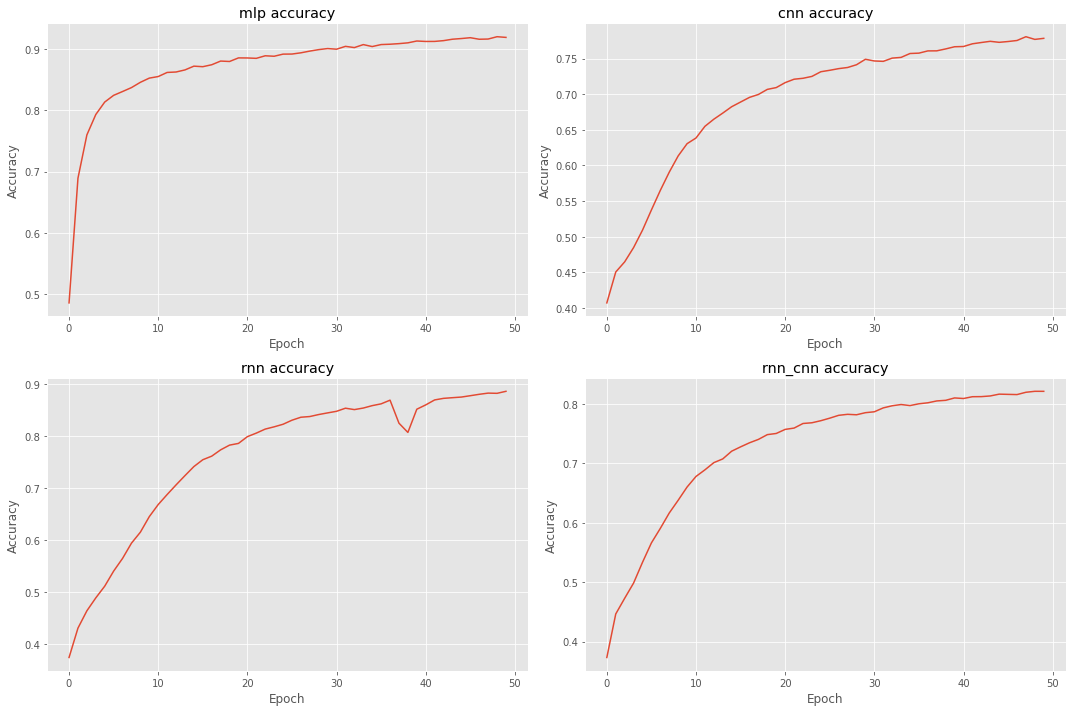

In [31]:
plot_metrics(model_dict,"accuracy","Epoch","Accuracy") ## Accuracy

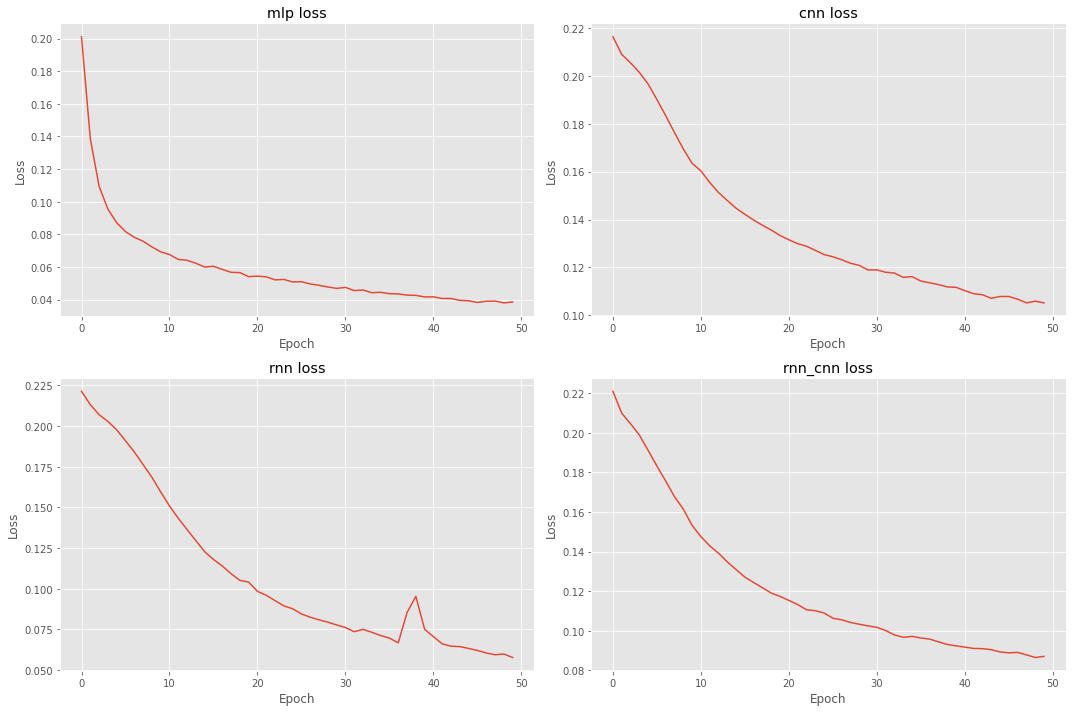

In [32]:
plot_metrics(model_dict,"loss","Epoch","Loss") ## Loss

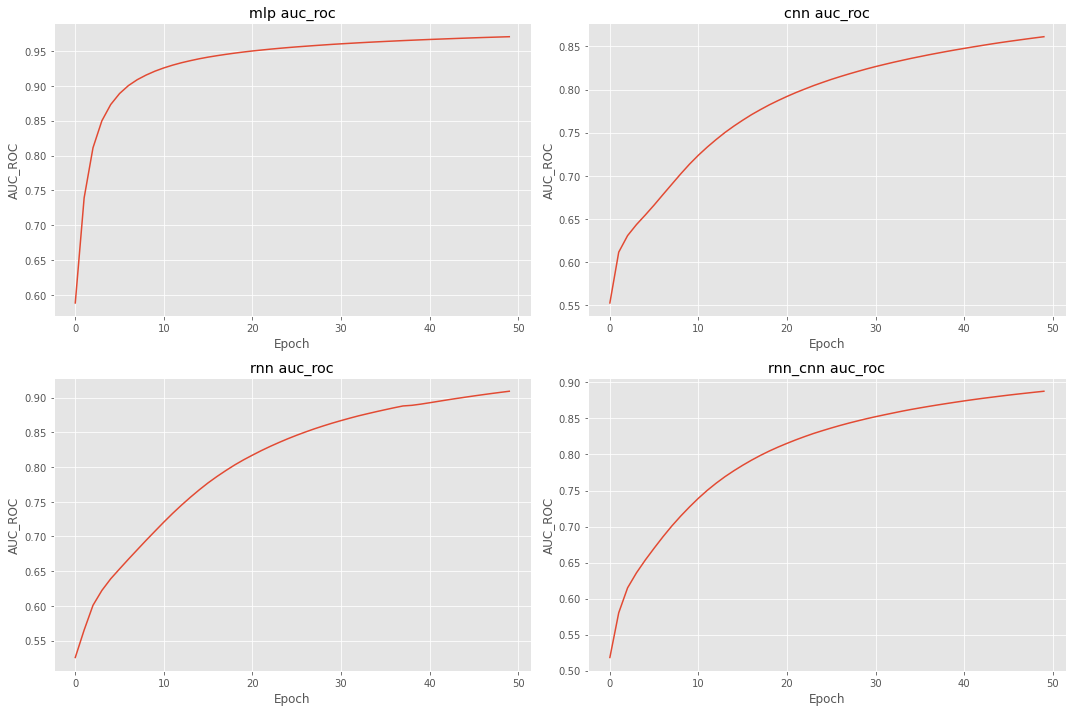

In [33]:
plot_metrics(model_dict,'auc_roc',"Epoch","AUC_ROC") ## AUC_ROC

In [62]:
print(model_dict["mlp"]['accuracy'][-1],model_dict["mlp"]['loss'][-1],model_dict["mlp"]['auc_roc'][-1])
print(model_dict["cnn"]['accuracy'][-1],model_dict["cnn"]['loss'][-1],model_dict["cnn"]['auc_roc'][-1])
print(model_dict["rnn"]['accuracy'][-1],model_dict["rnn"]['loss'][-1],model_dict["rnn"]['auc_roc'][-1])
print(model_dict["rnn_cnn"]['accuracy'][-1],model_dict["rnn_cnn"]['loss'][-1],model_dict["rnn_cnn"]['auc_roc'][-1])

0.9191085 0.03855042636096612 0.9705401
0.7783091 0.10522099050170072 0.8613091
0.8865026 0.05768934769333886 0.90905935
0.8215807 0.08709034995611477 0.88776517


#### Evalutation on trade (test) dataset

In [14]:
print("The percentage of up in y_test dataset is: {}%".format(round(y_test.up.sum()/y_test.shape[0],4)*100))
print("The percentage of stay in y_test dataset is: {}%".format(round(y_test.stay.sum()/y_test.shape[0],4)*100))
print("The percentage of down in y_test dataset is: {}%".format(round(y_test.down.sum()/y_test.shape[0],4)*100))

The percentage of up in y_test dataset is: 29.15%
The percentage of stay in y_test dataset is: 42.36%
The percentage of down in y_test dataset is: 28.49%


In [12]:
docs_test = tokenize_and_pad(docs_test.iloc[:,0])

In [13]:
mlp_model = load_model("../models/case1/mlp_case1_train_set00.hdf5", custom_objects = {'auc_roc': auc_roc})
mlp_model.evaluate([docs_test,X_test],y_test,batch_size=32)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.



5904/5904 [==============================] - 5s 763us/step


[0.31963979721392394, 0.4300474226474762, 0.5908804535865784]

In [ ]:
rnn_model = load_model("../models/case1/rnn_case1_train_set00.hdf5", custom_objects = {'auc_roc': auc_roc})
rnn_model.evaluate([docs_test,X_test],y_test,batch_size=32)

In [ ]:
rnn_cnn_model = load_model("../models/case1/rnn_cnn_case1_train_set00.hdf5", custom_objects = {'auc_roc': auc_roc})
rnn_cnn_model.evaluate([docs_test,X_test],y_test,batch_size=32)

#### Case 2

In [2]:
model_dict2 = dict()
model_dict2["mlp"]  = pickle.load(open("../models/case2/trainHistory/mlp_case2_train_set00.pkl","rb"))
model_dict2["cnn"] = pickle.load(open("../models/case2/trainHistory/cnn_case2_train_set00.pkl","rb"))
model_dict2["rnn"] = pickle.load(open("../models/case2/trainHistory/rnn_case2_train_set00.pkl","rb"))
model_dict2["rnn_cnn"] = pickle.load(open("../models/case2/trainHistory/rnn_cnn_case2_train_set00.pkl","rb"))

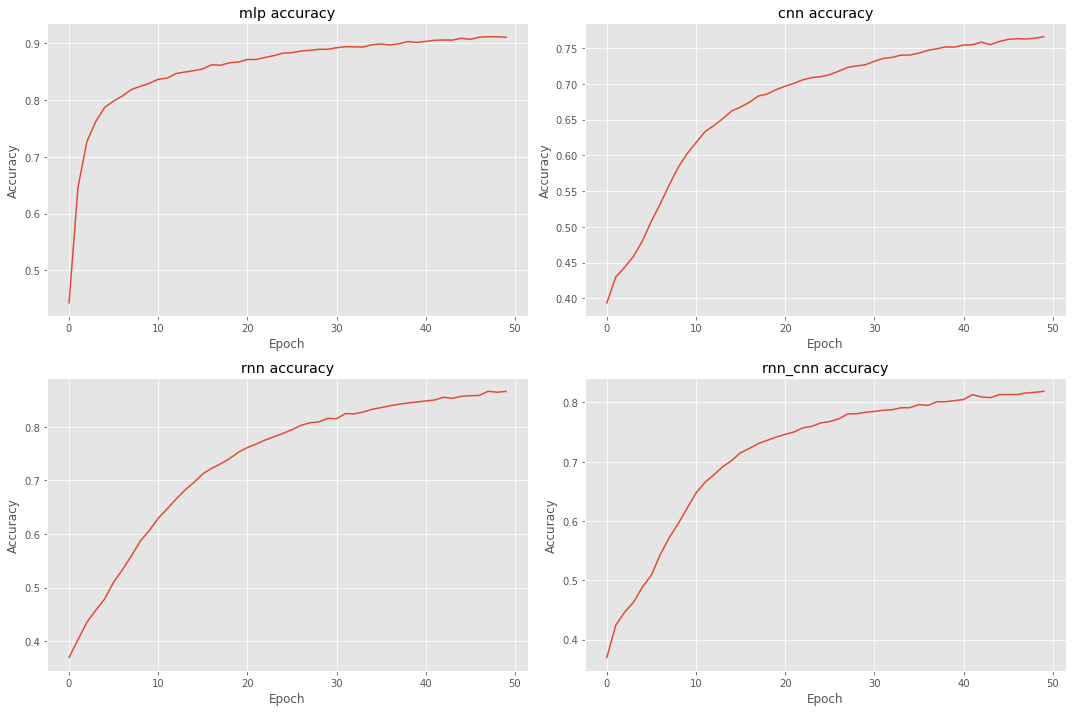

In [20]:
plot_metrics(model_dict2,"accuracy","Epoch","Accuracy") ## Accuracy

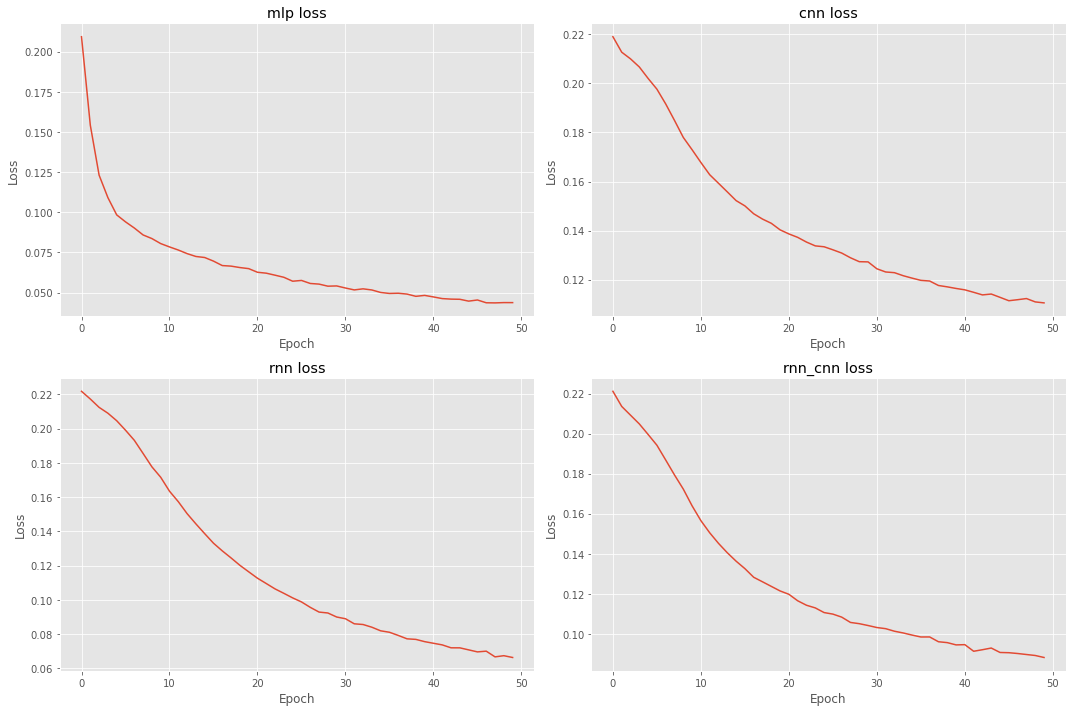

In [21]:
plot_metrics(model_dict2,"loss","Epoch","Loss") ## Loss

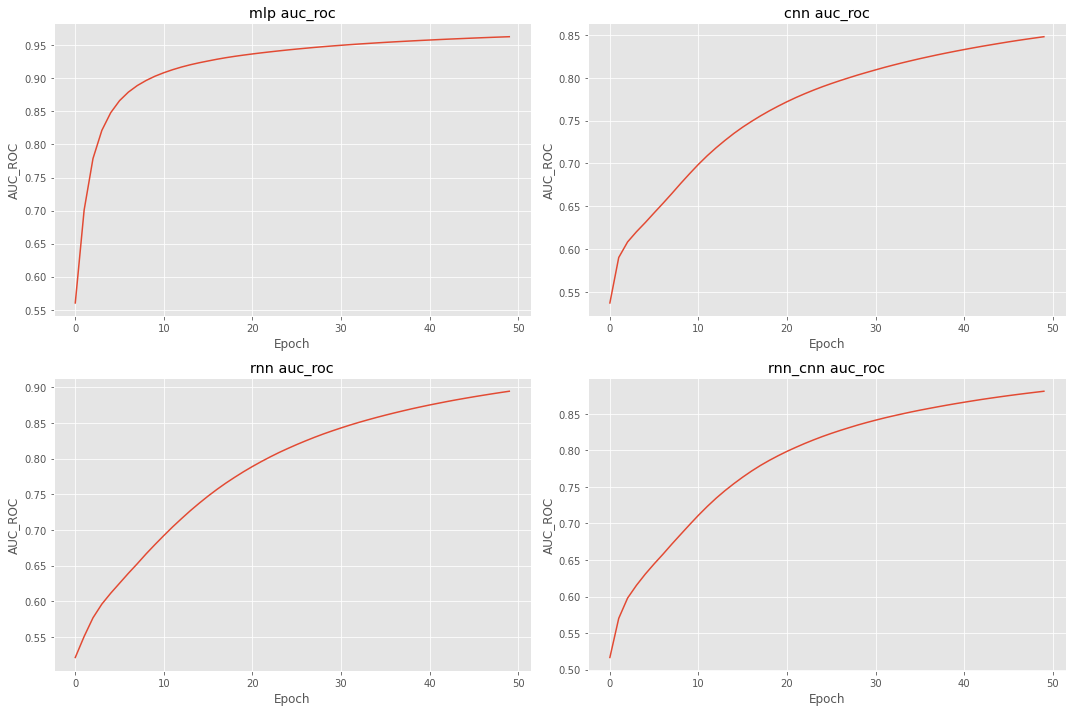

In [22]:
plot_metrics(model_dict2,'auc_roc',"Epoch","AUC_ROC") ## AUC_ROC

In [24]:
print(model_dict2["mlp"]['accuracy'][-1],model_dict2["mlp"]['loss'][-1],model_dict2["mlp"]['auc_roc'][-1])
print(model_dict2["cnn"]['accuracy'][-1],model_dict2["cnn"]['loss'][-1],model_dict2["cnn"]['auc_roc'][-1])
print(model_dict2["rnn"]['accuracy'][-1],model_dict2["rnn"]['loss'][-1],model_dict2["rnn"]['auc_roc'][-1])
print(model_dict2["rnn_cnn"]['accuracy'][-1],model_dict2["rnn_cnn"]['loss'][-1],model_dict2["rnn_cnn"]['auc_roc'][-1])

0.9107218 0.043727691415011184 0.9629353
0.765888 0.11054224441082901 0.8480359
0.86624736 0.06627968534867397 0.89460087
0.8187182 0.08818217226624596 0.88073456


In [10]:
X_test2,y_test2,docs_test2 = load_clean_dataset(ind = 0, train_set='N',case1 = "N")
print("The percentage of up in y_test2 dataset is: {}%".format(round(y_test2.up.sum()/y_test2.shape[0],4)*100))
print("The percentage of stay in y_test2 dataset is: {}%".format(round(y_test2.stay.sum()/y_test2.shape[0],4)*100))
print("The percentage of down in y_test2 dataset is: {}%".format(round(y_test2.down.sum()/y_test2.shape[0],4)*100))

Load test set 0
The percentage of up in y_test2 dataset is: 30.53%
The percentage of stay in y_test2 dataset is: 39.35%
The percentage of down in y_test2 dataset is: 30.11%


#### Summary of mlp, cnn, rnn, rnn_cnn (epoches 50), train set 0, test set 0 (Case 1)

##### True probability of test set 0

| Signal | Probability |
| --- | --- |
| up     | 0.2915 |
| stay   | 0.4236 |
| down   | 0.2849 |

##### Model (Train Set 0)

| Model  | Accuracy | Loss | ROC_AUC|
| ---    | --- | --- | --- |
| mlp    | 0.9191 | 0.0386 | 0.9705 |
| cnn    | 0.7783 | 0.1052 | 0.8613 |
| rnn    | 0.8865 | 0.0577 | 0.9091 |
| rnn+cnn| 0.8216 | 0.0871 | 0.8878 |


##### Model (Test Set 0)
| Model  | Accuracy | Loss | ROC_AUC|
| ---    | --- | --- | --- |
| mlp    | 0.4300 | 0.3196 | 0.5909 |
| cnn    | 0.3611 | 0.2885 | 0.5349 |
| rnn    | 0.3889 | 0.3262 | 0.5412 |
| rnn+cnn| 0.3564 | 0.3211 | 0.5266 |


#### Summary of mlp, cnn, rnn, rnn_cnn (epoches 50), train set 0, test set 0 (Case 2)

##### True probability of test set 0

| Signal | Probability |
| --- | --- |
| up     | 0.3053 |
| stay   | 0.3935 |
| down   | 0.3011 |

##### Model (Train Set 0)

| Model  | Accuracy | Loss | ROC_AUC|
| ---    | --- | --- | --- |
| mlp    | 0.9107 | 0.0437 | 0.9629 |
| cnn    | 0.7659 | 0.1105 | 0.8480 |
| rnn    | 0.8662 | 0.0663 | 0.8946 |
| rnn+cnn| 0.8187 | 0.0882 | 0.8807 |

##### Model (Test Set 0)
| Model  | Accuracy | Loss | ROC_AUC|
| ---    | --- | --- | --- |
| mlp    | 0.3934 | 0.3293 | 0.5512 |
| cnn    | 0.3692 | 0.2817 | 0.5438 |
| rnn    | 0.3837 | 0.3195 | 0.5468 |
| rnn+cnn| 0.3690 | 0.3021 | 0.5433 |

### Trading part for train and test set 0 with mlp method in case 2

In [7]:
from function2 import *
from function3 import *
from sklearn.metrics import roc_auc_score


max_words = 1508
embed_dim = 100

def tokenize_and_pad(docs,max_words=max_words):
    global t
    t = Tokenizer()
    t.fit_on_texts(docs)
    docs = pad_sequences(sequences = t.texts_to_sequences(docs),maxlen = max_words, padding = 'post')
    global vocab_size
    vocab_size = len(t.word_index) + 1
    
    return docs

def load_clean_dataset(ind = 0, train_set='Y',case1="Y"):
    if case1=="Y":
        case = "case1"
    else:
        case = "case2"
    train_ind = ind
    if train_set=='Y':
        print("Load train set {}".format(ind))
        start_date = periods1.iloc[train_ind,0]
        end_date = periods1.iloc[train_ind,1]
        file_name1 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/" + case+ "/train_set_"+ str(ind) + "_docs"+".csv"
        
    else:
        print("Load test set {}".format(ind))
        start_date = periods1.iloc[train_ind,1]
        end_date = periods1.iloc[train_ind,2]
        file_name1 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_X"+".csv"
        file_name2 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_y"+".csv"
        file_name3 = "../clean_data/dataset/" + case +"/test_set_"+ str(ind) + "_docs"+".csv"
        
    X = pd.read_csv(file_name1)
    y = pd.read_csv(file_name2)
    docs = pd.read_csv(file_name3)
    
    return X,y,docs

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true,y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value



df = pd.read_csv("../clean_data/lemmatized_text_case2.csv",parse_dates =['release_date'])

train_ind=0
start_date = periods1.iloc[train_ind,1]
end_date = periods1.iloc[train_ind,2]
df_cur = df[(df.release_date>=start_date) & (df.release_date<=end_date)]
#print(df_cur.shape)
#docs = tokenize_and_pad(docs)
ticker = df_cur['ticker']
time_ind = df_cur['release_date']


X_train2,y_train2,docs_train2= load_clean_dataset(ind = train_ind, train_set='Y',case1="N")
X_test2,y_test2,docs_test2= load_clean_dataset(ind = train_ind, train_set='N',case1="N")

aux_shape = len(X_train2.columns)
cont_features = ['vix','rm_week','rm_month', 'rm_qtr', 'rm_year']
#aux_features = cont_features + [item for item in mlb.classes_]
aux_features = cont_features
x_scaler = StandardScaler()
X_train2[cont_features] = x_scaler.fit_transform(X_train2[cont_features])
X_test2[cont_features] = x_scaler.transform(X_test2[cont_features])


docs_test2 = tokenize_and_pad(docs_test2.iloc[:,0])

if train_ind <10:
    set_id = "0"+str(train_ind)
else:
    set_id = str(train_ind )
    
filename = "../models/case2/mlp_case2_train_set"+set_id+".hdf5"
mlp_model = load_model(filename, custom_objects = {'auc_roc': auc_roc})

y_prob = mlp_model.predict([docs_test2,X_test2])
y_prob = pd.DataFrame(y_prob,columns = ['down','stay','up'])
df_prob = pd.concat([df_cur[['ticker','release_date']].reset_index(drop=True),y_prob],axis=1)
# set market date
df_prob['market_close'] = df_prob.release_date.apply(lambda x:x.replace(hour=16,minute=0,second=0))
df_prob['market_open'] = df_prob.release_date.apply(lambda x:x.replace(hour=9,minute=30,second=0))
# select max probability not for stay
df_prob_trad = df_prob[df_prob[['down','stay','up']].idxmax(axis=1)!='stay']
## sort bu date ascending
df_prob_trad.sort_values(by=['release_date'],inplace=True)


##get unique trade_date
close_date = df_prob_trad.market_close.unique()
##long or short max k stocks in a day
k = 100
ret_avg = []
print("start trading for set {}".format(train_ind))
trad_day_up = []
trad_day_down = []
close_date_new = []
for i in range(len(close_date)):
    nums_up1 = 0
    nums_down1 =0
    up_ret = []
    down_ret = []
    df_subset = df_prob_trad[df_prob_trad['market_close']==close_date[i]]
    ##check if released before the market, if before the market, return happened in today, else return happened in next day
    
    df_subset_cur = df_subset[df_subset.release_date<df_subset.market_open]
    if i>0:
        df_subset_cur = pd.concat([df_subset_cur.reset_index(drop=True),df_subset_next],axis=0)
    
    ##move to next close day
    df_subset_next = df_subset[df_subset.release_date>=df_subset.market_open]
    
    #print(df_subset_cur)
    df_subset_up = df_subset_cur[df_subset_cur.up>df_subset_cur.down]
    df_subset_down = df_subset_cur[df_subset_cur.up<df_subset_cur.down]
    #print(df_subset_up.shape[0])
    #print(df_subset_down.shape[0])
    nums_up = df_subset_up.shape[0]
    nums_down = df_subset_down.shape[0]
    if nums_up>0:
        df_subset_up = df_subset_up.sort_values(by=['up'],ascending=False)
        df_subset_up  = df_subset_up.head(k)
        nums_up1 = df_subset_up.shape[0]
        for j in range(nums_up1):
            up_ret.append(get_return(df_subset_up.iloc[0,:]))
            #up_ret.append(get_return2(df_subset_up.iloc[0,:]))
        #print(up_ret)
        #print("up", df_subset_up)
    else:
        up_ret.append(0)
    if nums_down>0:
        df_subset_down = df_subset_down.sort_values(by=['down'],ascending=False)
        df_subset_down = df_subset_down.head(k)
        nums_down1 = df_subset_down.shape[0]
        for j in range(nums_down1):
            down_ret.append(-get_return(df_subset_down.iloc[0,:]))
            #down_ret.append(-get_return2(df_subset_down.iloc[0,:]))
        #print(down_ret)
    else:
        down_ret.append(0)
        
    if (nums_up1!=0 or nums_down1!=0):
        ret_avg_cur = (np.sum(up_ret)+np.sum(down_ret))/(nums_up1+nums_down1)
        ret_avg.append(ret_avg_cur)
        close_date_new.append(close_date[i])
        print("For Close Day: {}, return: {}".format(close_date[i],round(ret_avg_cur,4)))

Load train set 0
Load test set 0


G:\Data\Machine_Learning_Library\learn_others\learn_from_others\lib\site-packages\ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


start trading for set 0
For Close Day: 2008-01-03T16:00:00.000000000, return: 0.003
For Close Day: 2008-01-04T16:00:00.000000000, return: -0.001
For Close Day: 2008-01-07T16:00:00.000000000, return: 0.0037
For Close Day: 2008-01-08T16:00:00.000000000, return: -0.0378
For Close Day: 2008-01-09T16:00:00.000000000, return: 0.0119
For Close Day: 2008-01-10T16:00:00.000000000, return: 0.0305
For Close Day: 2008-01-11T16:00:00.000000000, return: -0.0107
For Close Day: 2008-01-14T16:00:00.000000000, return: -0.0092
For Close Day: 2008-01-15T16:00:00.000000000, return: 0.0123
For Close Day: 2008-01-16T16:00:00.000000000, return: -0.0044
For Close Day: 2008-01-17T16:00:00.000000000, return: -0.0082
For Close Day: 2008-01-18T16:00:00.000000000, return: 0.0119
For Close Day: 2008-01-22T16:00:00.000000000, return: 0.0082
For Close Day: 2008-01-23T16:00:00.000000000, return: -0.0113
For Close Day: 2008-01-24T16:00:00.000000000, return: -0.0085
For Close Day: 2008-01-25T16:00:00.000000000, return: 0

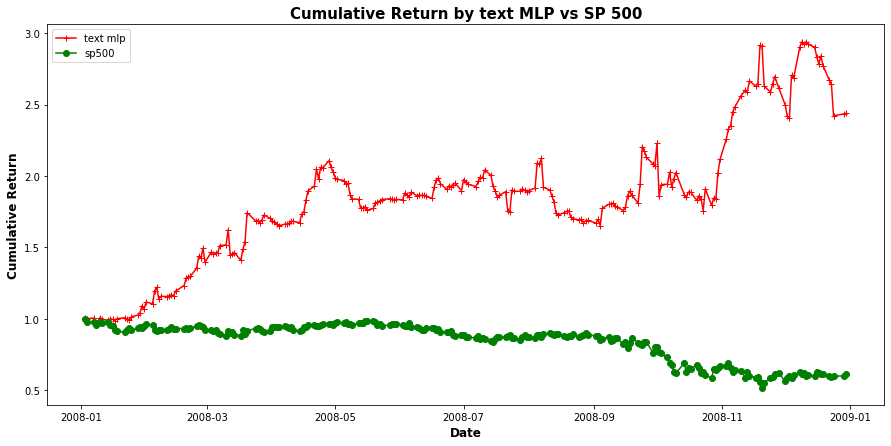

In [8]:
ret_avg1 = [1+ret for ret in ret_avg]
cum_avg = np.cumprod(ret_avg1)
ret_cum =pd.DataFrame()
ret_cum['date'] = close_date_new
ret_cum['cum_ret'] = cum_avg

##get common date
ret_cum_date = [datetime.strftime(x, '%Y-%m-%d') for x in ret_cum.date]
ret_cum['date'] = pd.to_datetime(ret_cum_date, format='%Y-%m-%d')
# get common date of gspc and ret from mlp
com_date = gspc_df.index[gspc_df.index.isin(ret_cum_date)]
sp500_close = gspc_df.loc[gspc_df.index.isin(com_date),'Adj Close']
sp500_ret = sp500_close.pct_change()
##reset first day's return
sp500_ret[0] = (gspc_df.loc[gspc_df.index==com_date[0],'Adj Close']-gspc_df.loc[gspc_df.index==com_date[0],'Open'])/gspc_df.loc[gspc_df.index==com_date[0],'Open']

sp500_avg1 = [1+ret for ret in sp500_ret]
sp500_avg = np.cumprod(sp500_avg1)
sp500_cum =pd.DataFrame()
sp500_cum['date'] = com_date
sp500_cum['cum_ret'] = sp500_avg

#adjust ret_cum with common date
ret_cum = ret_cum.loc[ret_cum.date.isin(com_date),:]

fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(1,1,1)
ax.plot(ret_cum.date,ret_cum.cum_ret, color = 'r', marker ='+', label='text mlp')
ax.plot(sp500_cum.date, sp500_cum.cum_ret, color = 'g', marker ='o', label='sp500')
ax.set_xlabel('Date',fontweight = 'bold', fontsize=12)
ax.set_ylabel('Cumulative Return', fontweight = 'bold', fontsize=12)
ax.set_title("Cumulative Return by text MLP vs SP 500", fontweight='bold', fontsize = 15)
ax.legend()